# Demonstration of Regression Using Kaggle Data for Housing Price Prediction

Use the Ames house price prediction data obtained from Kaggle. This is relatively small dataset, and thus suitable for demonstration purpose. 

## Load packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
plt.style.use("ggplot")

%matplotlib inline
%config InlineBackend.figure_formats = ("svg", "retina")

In [3]:
for item in os.listdir("./data"):
    print(item)

data_description
test.csv
train.csv
train_top5.csv
sample_submission.csv


In [74]:
!cat ./data/data_description

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

## Load data

In [4]:
train_path = "./data/train.csv"
test_path = "./data/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [5]:
train.shape # (1460, 81)

(1460, 81)

In [6]:
train_numeric = (train.select_dtypes(["int64", "float64"])
                 .drop("Id", axis=1)
                 .dropna() # removed missing values
                )

train_numeric.shape # (1121, 37)

(1121, 37)

In [7]:
train_label = train_numeric["SalePrice"]
train_data = train_numeric.drop(["SalePrice"], axis=1)

## Variable correlations 

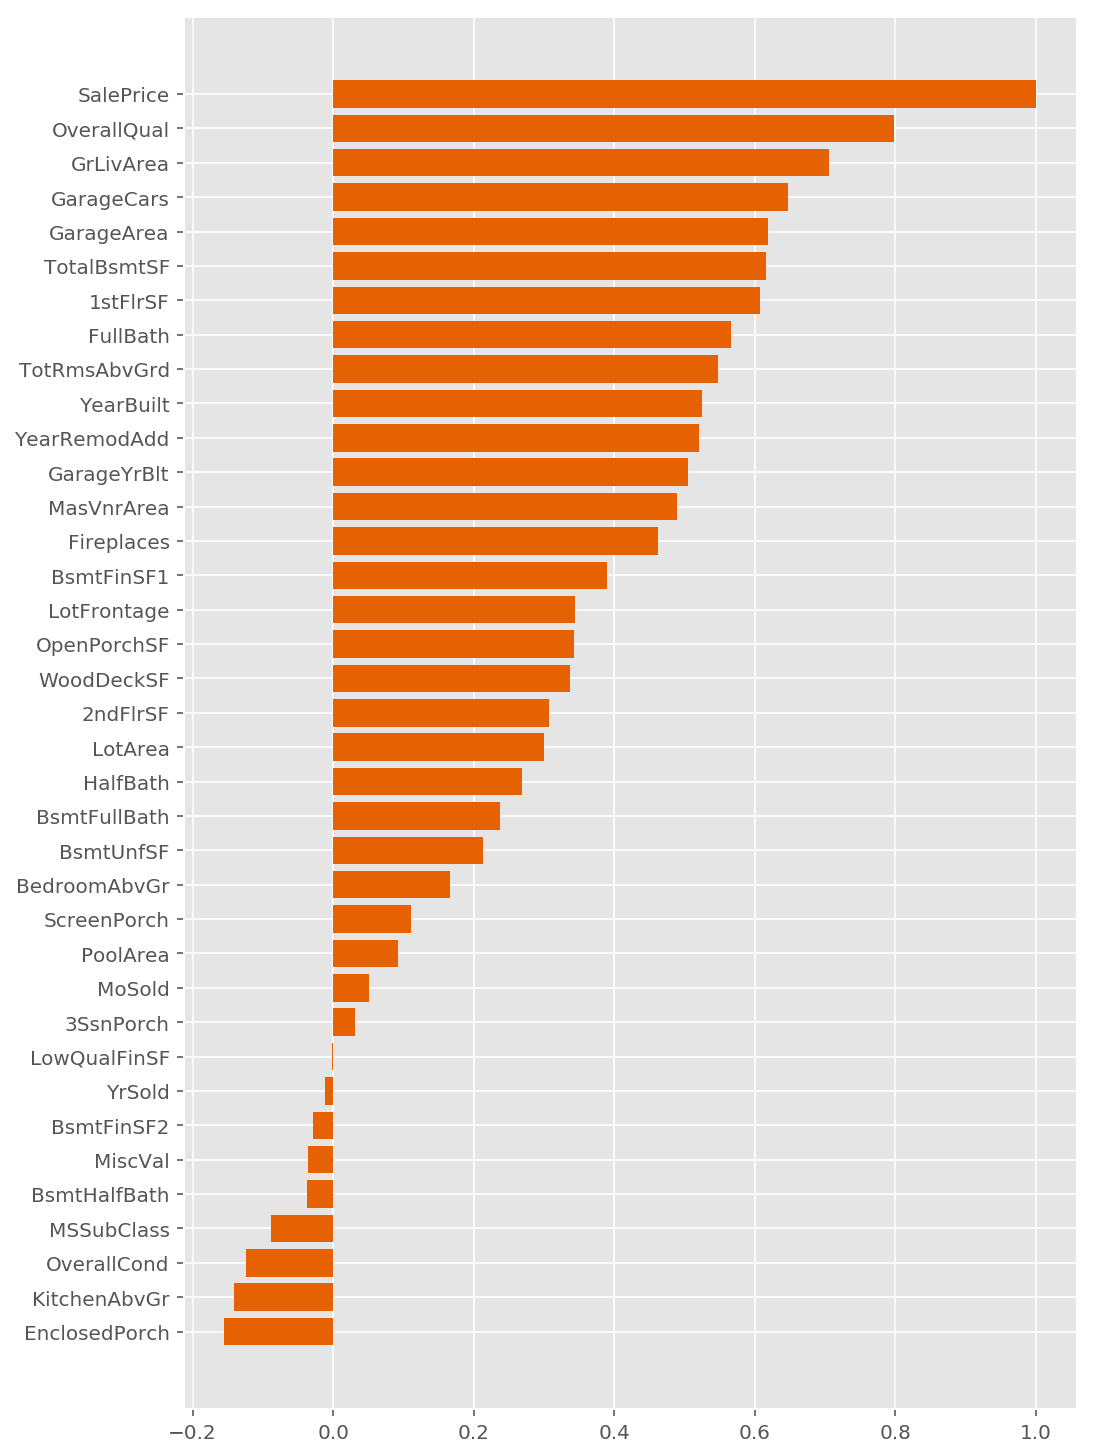

In [8]:
price_corr = (train_numeric
              .corr()["SalePrice"]
             .sort_values(ascending=True))
positions = np.arange(len(price_corr))

plt.subplots(figsize=(8, 8*1.6))
plt.barh(positions, price_corr, color=colors[0])
plt.yticks(positions, price_corr.index)
plt.show()

In [11]:
corr = train_numeric.corr()

with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(10, 10*1.2))
    sns.set(font_scale=1)
    cbar_ax = fig.add_axes([.905, .3, .05, .3])
    sns.heatmap(corr, vmax=1, 
                cmap="viridis", 
                cbar_ax=cbar_ax,
                ax=ax,
                cbar=True,
                square=True)
    #ax.set_xticklabels(labels=corr.index, rotation=60)
    plt.show()

In [10]:
# use the five variables with largest correlations
# include also the `SalePrice`
top_5 = price_corr[-6:].index
train_numeric["SalePrice"] = np.log(train_numeric.loc[:, "SalePrice"])

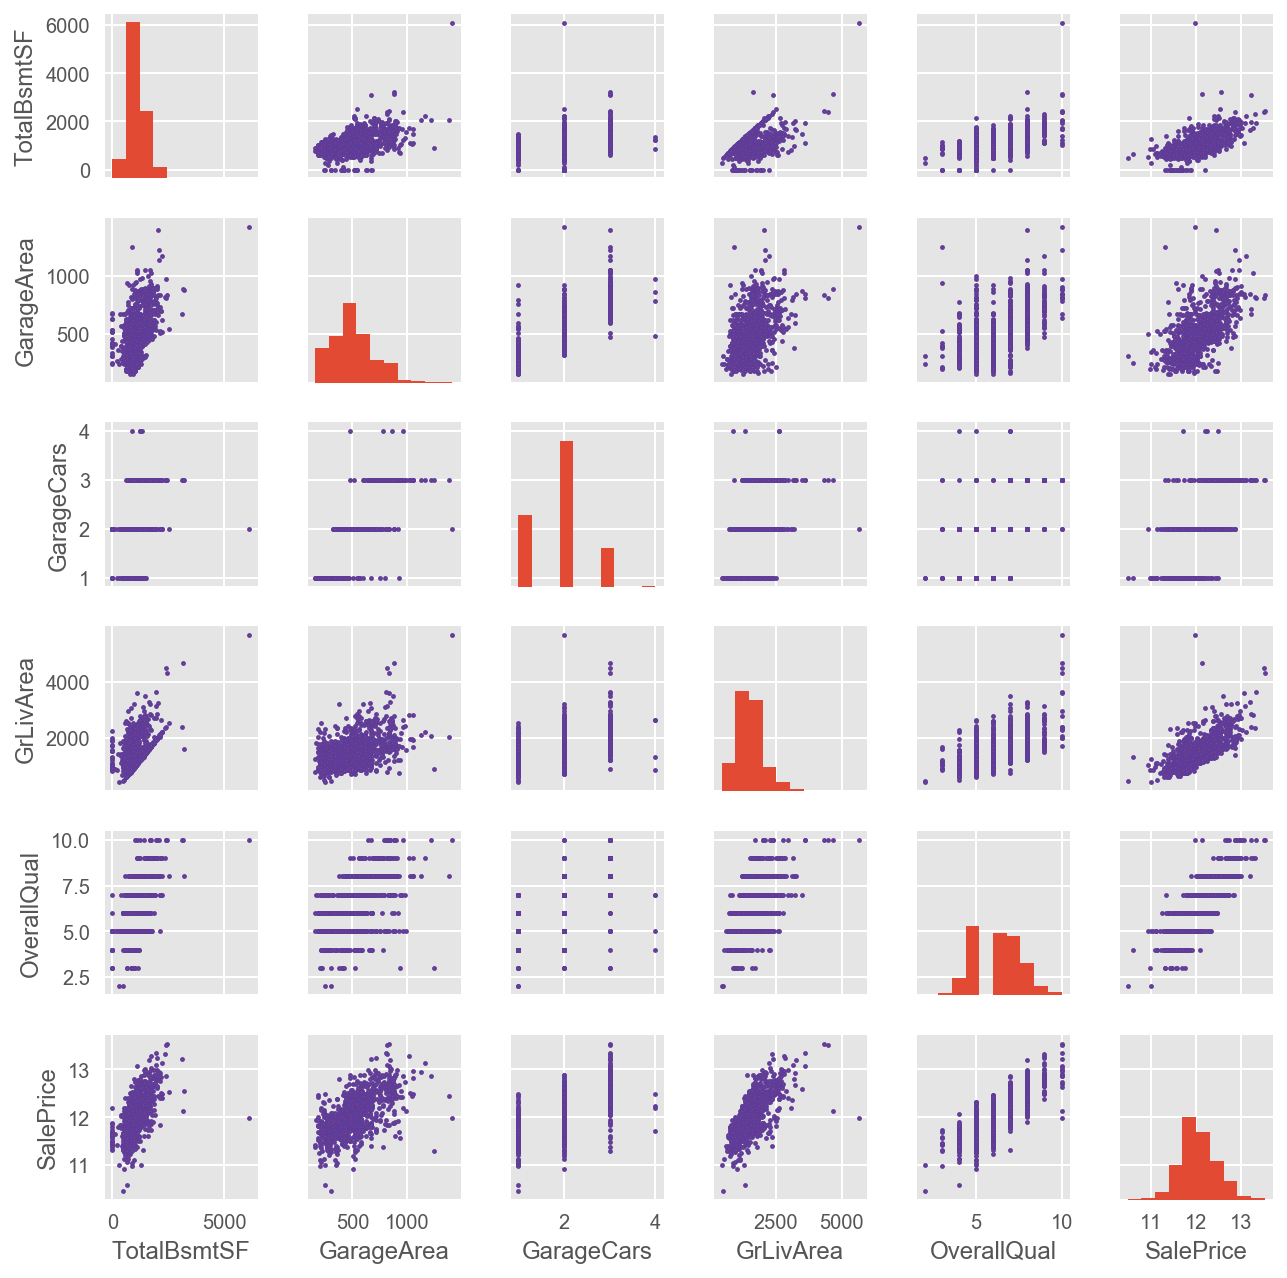

In [12]:
with plt.style.context("ggplot"):
    sns.pairplot(train_numeric[top_5],
                 size=1.5,
                 plot_kws=dict(s=2, edgecolor=colors[3], linewidth=1))
    plt.show()

## Linear Regression

In [13]:
top_5

Index(['TotalBsmtSF', 'GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual',
       'SalePrice'],
      dtype='object')

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## shuffle data before regression
train_numeric = train_numeric.iloc[np.random.permutation(train_numeric.shape[0]),:]
test_data = test[top_5[:-1]].dropna()

## standardize data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_numeric[top_5[:-1]]).astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(train_scaled,
                                                  train_numeric["SalePrice"],
                                                  test_size=0.2)

test_scaled = scaler.transform(test_data)

## Vanilla Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import r2_score as R2, mean_absolute_error as MAE

lin_reg = LinearRegression()
lin_reg.fit(X=X_train, y=y_train)
y_pred = lin_reg.predict(X_val)

print(f"R2={R2(y_pred, y_val):.3f}, MAE={MAE(y_val, y_pred):.3f}")

R2=0.749, MAE=0.129


Validation $R^2=0.747, MAE=0.129

## Huber regression

In [16]:
huber_reg = HuberRegressor(alpha=0.5)
huber_reg.fit(X=X_train, y=y_train)
ypred_huber = huber_reg.predict(X_val)
print(f"R2={R2( y_val, ypred_huber):.3f}, MAE={MAE(y_val, ypred_huber):.4f}")

R2=0.804, MAE=0.1237


Validation $R^2=0.804, MAE=0.1237

## XGBoost

In [17]:
from xgboost import  XGBRegressor

# params_dict should be determined via some searching algorithms: GridSearchCV and
# RandonmizedSearchCV
params_dict = { "objective": "reg:linear",
               "booster":"gbtree",
               "loss":"mae",
               "learning_rate": 1e-2,              
               "max_depth":10,
               "subsample": 0.7,
               "colsample_bytree": 0.8,
               "gamma":0.1,
               # "reg_alpha":, #l1 regularization
               # "reg_lambda":, #l2 regularization
               "n_jobs":-1,
               "n_estimators": 1000}

xgb_reg = XGBRegressor(**params_dict)
xgb_reg.fit(X_train, y_train, 
            verbose=0,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric='mae')

ModuleNotFoundError: No module named 'xgboost'

In [84]:
ypred_xgb = xgb_reg.predict(X_val)
print(f"XBGBoost R2={R2(y_val, ypred_xgb):.3f}")

XBGBoost R2=0.849


Validation $R^2=0.849$, got some decent improvement.

## Keras

In [43]:
# https://github.com/keras-rl/keras-rl/blob/master/rl/util.py
import keras.backend as K
def huber_loss(y_true, y_pred, clip_value=0.01):
    # Huber loss, see https://en.wikipedia.org/wiki/Huber_loss and
    # https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b
    # for details.
    assert clip_value > 0.

    x = y_true - y_pred
    if np.isinf(clip_value):
        # Spacial case for infinity since Tensorflow does have problems
        # if we compare `K.abs(x) < np.inf`.
        return .5 * K.square(x)

    condition = K.abs(x) < clip_value
    squared_loss = .5 * K.square(x)
    linear_loss = clip_value * (K.abs(x) - .5 * clip_value)
    if K.backend() == 'tensorflow':
        import tensorflow as tf
        if hasattr(tf, 'select'):
            return tf.select(condition, squared_loss, linear_loss)  # condition, true, false
        else:
            return tf.where(condition, squared_loss, linear_loss)  # condition, true, false
    elif K.backend() == 'theano':
        from theano import tensor as T
        return T.switch(condition, squared_loss, linear_loss)
    else:
        raise RuntimeError('Unknown backend "{}".'.format(K.backend()))

Using TensorFlow backend.


In [308]:
from keras import models, layers, optimizers, losses

D_in, H1, H2, D_out = 5, 1000, 50, 1

model = models.Sequential()
model.add(layers.Dense(H1, input_shape=(D_in, ), activation='relu'))
model.add(layers.Dense(H2, input_shape=(H1, ), activation='relu'))
model.add(layers.Dense(D_out, activation=None))

model.compile(loss=huber_loss,
              metrics=['mae'],
              optimizer=optimizers.Adam(lr=1e-3)
             )

history = model.fit(X_train, y_train,
                    validation_data = (X_val, y_val),
                    batch_size=32, epochs=80, shuffle=False)

MAE_ = model.evaluate(X_val, y_val, verbose=0)

print(f'Dense NN  test MAE={MAE_[0]:.3f}')

Train on 896 samples, validate on 225 samples
Epoch 1/80
896/896 [==============================] - 1s 863us/step - loss: 0.0833 - mean_absolute_error: 8.3348 - val_loss: 0.0397 - val_mean_absolute_error: 3.9704
Epoch 2/80
896/896 [==============================] - 0s 63us/step - loss: 0.0348 - mean_absolute_error: 3.4836 - val_loss: 0.0193 - val_mean_absolute_error: 1.9358
Epoch 3/80
896/896 [==============================] - 0s 65us/step - loss: 0.0162 - mean_absolute_error: 1.6225 - val_loss: 0.0093 - val_mean_absolute_error: 0.9354
Epoch 4/80
896/896 [==============================] - 0s 63us/step - loss: 0.0095 - mean_absolute_error: 0.9511 - val_loss: 0.0064 - val_mean_absolute_error: 0.6444
Epoch 5/80
896/896 [==============================] - 0s 62us/step - loss: 0.0061 - mean_absolute_error: 0.6147 - val_loss: 0.0040 - val_mean_absolute_error: 0.4025
Epoch 6/80
896/896 [==============================] - 0s 62us/step - loss: 0.0039 - mean_absolute_error: 0.3980 - val_loss: 0.00

In [320]:
ypred_nn = model.predict(X_val)
print(f"NN validation R2={R2(y_val, ypred_nn):.3f}, MAE={MAE_[0]:.3f}")

NN validation R2=0.795, MAE=0.001


## Tensorflow

In [20]:
import tensorflow as tf

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [19]:
features, label = X_train, y_train
def train_input_fn(features, labels, batch_size):
    # transform inputs into a dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    
    # shuffle, repeat, and batch the examples
    dataset = dataset.shuffle(1e4).repeat().batch(batch_size)
    
    # return the dataset
    return dataset

In [34]:
##train[top_5].dropna().to_csv("./data/train_top5.csv", index=False)
top5_path = "./data/train_top5.csv"
train_top5 = tf.data.TextLineDataset(top5_path).skip(1)

In [37]:
COLUMNS = top_5
FIELD_DEFAULTS = [[0.0] for i in range(6)]
def _parse_line(line):
    fields = tf.decode_csv(line, FIELD_DEFAULTS)
    
    # pack results into a dictionary
    features = dict(zip(COLUMNS, fields))
    
    # separate the label from the features
    label = features.pop('SalePrice')
    
    return features, label

In [38]:
def csv_input_fn(csv_path, batch_size):
    # create a dataset containing the text lines
    dataset = tf.data.TextLineDataset(csv_path).skip(1)
    
    # parse each line
    dataset = dataset.map(_parse_line)
    
    #shuffle, repeat, and batch the examples
    dataset = dataset.shuffle(10000).repeat().batch(batch_size)
    
    # return the dataset
    return dataset

In [39]:
ds = csv_input_fn(top5_path, batch_size=64)
print(ds)

<BatchDataset shapes: ({TotalBsmtSF: (?,), GarageArea: (?,), GarageCars: (?,), GrLivArea: (?,), OverallQual: (?,)}, (?,)), types: ({TotalBsmtSF: tf.float32, GarageArea: tf.float32, GarageCars: tf.float32, GrLivArea: tf.float32, OverallQual: tf.float32}, tf.float32)>


## Use a premade tensorflow for regression

In [41]:
feature_columns = [
    tf.feature_column.numeric_column(name)
    for name in top_5[:-1] ]
feature_columns

[_NumericColumn(key='TotalBsmtSF', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='GarageArea', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='GarageCars', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='GrLivArea', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='OverallQual', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

In [42]:
feature_columns = [
    tf.feature_column.numeric_column(name)
    for name in top_5[:-1] ]
tf_reg = tf.estimator.LinearRegressor(feature_columns)
batch_size = 64
tf_reg.train(steps=1000,
             input_fn=lambda: csv_input_fn(top5_path, batch_size))

INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/9n/tb4zf7tn0xvgkyx61j3fvvkw0000gn/T/tmpdxcf6cvj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a31690048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 1 into /var/folders/9n/tb4zf7tn0xvgkyx61j3fvvkw0000gn/T/tmpdxcf6cvj/model.ckpt.


INFO:tensorflow:loss = 80194664.0, step = 1


INFO:tensorflow:global_step/sec: 365.084


INFO:tensorflow:loss = 6830484.5, step = 101 (0.275 sec)


INFO:tensorflow:global_step/sec: 441.026


INFO:tensorflow:loss = 9272814.0, step = 201 (0.227 sec)


INFO:tensorflow:global_step/sec: 378.497


INFO:tensorflow:loss = 8175688.0, step = 301 (0.264 sec)


INFO:tensorflow:global_step/sec: 478.361


INFO:tensorflow:loss = 5923940.5, step = 401 (0.209 sec)


INFO:tensorflow:global_step/sec: 481.3


INFO:tensorflow:loss = 7146955.0, step = 501 (0.208 sec)


INFO:tensorflow:global_step/sec: 409.212


INFO:tensorflow:loss = 7032310.0, step = 601 (0.244 sec)


INFO:tensorflow:global_step/sec: 430.265


INFO:tensorflow:loss = 8110397.0, step = 701 (0.232 sec)


INFO:tensorflow:global_step/sec: 350.539


INFO:tensorflow:loss = 8801210.0, step = 801 (0.285 sec)


INFO:tensorflow:global_step/sec: 423.9


INFO:tensorflow:loss = 6278583.5, step = 901 (0.236 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /var/folders/9n/tb4zf7tn0xvgkyx61j3fvvkw0000gn/T/tmpdxcf6cvj/model.ckpt.


INFO:tensorflow:Loss for final step: 6045591.0.


In [ ]:
def test_input_fn(features, label, batch_size):
    # pass
    # return dataset

In [ ]:
 y_pred_iter = rf_reg.predict(input_fn=test_input_fn) # some test_input_fn
 ypred_tf = list(y_pred_iter)
 y_pred[0]